# Pytorch homework
## 作業說明
這次的作業總共有5個部份，在每一個部份會有一些被註解框起來的區塊需要完成。
1. Preparation: 我們會利用CIFAR-10 dataset **(10%)**
2. Pytorch Module API: 在這邊我們會利用 nn.Module 建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
3. Pytorch ModuleList API: 在這邊我們 nn.ModuleList 以及 nn.Module來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
4. Pytorch Sequential API: 在這邊我們 nn.Sequential 來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
5. CIFAR-10 open-ended challenge: 在這邊請大家建構屬於自己的CNN，並且盡量的得到高準確度，並解釋如何建構的 **(30%)**
    * 可以嘗試建構任意的layer, optimizer或是 hyperparameters等
    * 由於並不是所有同學都有GPU可以提供training，因此這題分數的分配不是根據最後的準確度而給分，而是達到baseline之後便會給於全部的分數
    * **Baseline: 65% on testing data**
    
## 作業繳交
* Deadline : 11/06 中午12:00
    * **遲交一天的打7折**
    * **遲交一天以上的打5折**
* 繳交方式 : 請繳交這個ipynb檔至moodle
* 作業命名 : (你的學號)\_(姓名)\_hw2.ipynb  (ex.F71112222_人工智.ipynb) 
    * **格式不對的話會扣10分！！！**
* 有任何問題歡迎寄信至我的信箱
    * 黃顯堯 e0928021388@gmail.com


## Part1 Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

from torchviz import make_dot, make_dot_from_trace

### Setting
你可以根據需求調整epochs, batch size等等的參數

In [27]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

EPOCHS = 5
BATCH_SIZE = 64
PRINT_FREQ = 100
TRAIN_NUMS = 49000

CUDA = True

PATH_TO_SAVE_DATA = "./"

### Load CIFAR-10 dataset

In [3]:
data_transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
                  ])

train_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=True,
                              download=True, transform=data_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(range(TRAIN_NUMS)))
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        sampler=SubsetRandomSampler(range(TRAIN_NUMS, 50000)))



test_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=False,
                             download=True, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


### GPU setting
可以根據選擇是否要使用gpu，在本次的作業沒有一定要使用到gpu，假如你沒有安裝cuda，torch.cuda.is_available會return False

In [31]:
if CUDA:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda


### Trainer
我們有提供Trainer讓同學可以training自己建構的model

In [22]:
class Trainer:
    def __init__(self, criterion, optimizer, device):
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.device = device
        
    def train_loop(self, model, train_loader, val_loader):
        for epoch in range(EPOCHS):
            print("---------------- Epoch {} ----------------".format(epoch))
            self._training_step(model, train_loader, epoch)
            
            self._validate(model, val_loader, epoch)
    
    def test(self, model, test_loader):
            print("---------------- Testing ----------------")
            self._validate(model, test_loader, 0, state="Testing")
            
    def _training_step(self, model, loader, epoch):
        model.train()
        
        for step, (X, y) in enumerate(loader):
            X, y = X.to(self.device), y.to(self.device)
            N = X.shape[0]
            
            self.optimizer.zero_grad()
            outs = model(X)
            loss = self.criterion(outs, y)
            
            if step >= 0 and (step % PRINT_FREQ == 0):
                self._state_logging(outs, y, loss, step, epoch, "Training")
            
            loss.backward()
            self.optimizer.step()
            
    def _validate(self, model, loader, epoch, state="Validate"):
        model.eval()
        outs_list = []
        loss_list = []
        y_list = []
        
        with torch.no_grad():
            for step, (X, y) in enumerate(loader):
                X, y = X.to(self.device), y.to(self.device)
                N = X.shape[0]
                
                outs = model(X)
                loss = self.criterion(outs, y)
                
                y_list.append(y)
                outs_list.append(outs)
                loss_list.append(loss)
            
            y = torch.cat(y_list)
            outs = torch.cat(outs_list)
            loss = torch.mean(torch.stack(loss_list), dim=0)
            self._state_logging(outs, y, loss, step, epoch, state)
                
                
    def _state_logging(self, outs, y, loss, step, epoch, state):
        acc = self._accuracy(outs, y)
        print("[{:3d}/{}] {} Step {:03d} Loss {:.3f} Acc {:.3f}".format(epoch+1, EPOCHS, state, step, loss, acc))
            
    def _accuracy(self, output, target):
        batch_size = target.size(0)

        pred = output.argmax(1)
        correct = pred.eq(target)
        acc = correct.float().sum(0) / batch_size

        return acc

### Flatten

In [44]:
def flatten(x):
    ###############################################################################
    #                   TODO : Read the input in (N, C, W, H)                     #
    #                          "Flatten" into (N, C*W*H)                          #                   
    ###############################################################################
    x = x.view(x.size(0), -1).cuda()
    ###############################################################################
    #                            END TO DO                                        #
    ###############################################################################
    return x

def test_flatten():
    x = torch.zeros((10, 3, 32, 32)).cuda()
    print("Before flattening:", x.shape)
    print("After flattening:", flatten(x).shape) # Expected output (10, 3072) 
    
test_flatten()

Before flattening: torch.Size([10, 3, 32, 32])
After flattening: torch.Size([10, 3072])


## Part2 : Module API
In this part, you have to complete the implentation of CNN with Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

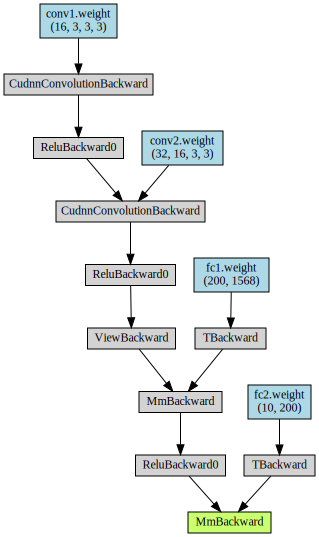

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1, self.conv2 = None, None
        self.fc1, self.fc2 = None, None
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################
        ## Bias set to false to match the structure that TA gave
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, bias=False).cuda() # cudaconv1.weight(16, 3, 3, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, bias=False).cuda() # conv2.weight(32, 16, 3, 3)
        self.fc1 = nn.Linear(1568, 200, bias=False).cuda() # fc1.weight(200, 1568)
        self.fc2 = nn.Linear(200, 10, bias=False).cuda() # fc2.weight(10, 200)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################
        
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################
        x = F.relu(self.conv1(x)).cuda() # conv1.weight -> relubackward0
        x = F.relu(self.conv2(x)).cuda() # conv2.weight -> relubackward0
        x = flatten(x).cuda() # viewbackward
        x = F.relu(self.fc1(x)).cuda() # fc1.weight -> relubackward0
        x = self.fc2(x).cuda() # fc2.weight
        out = x
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################        

        return out
        

model = CNN()
x = torch.zeros((BATCH_SIZE, 3, 32, 32)).cuda()
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.302 Acc 0.117
[  1/5] Training Step 100 Loss 2.261 Acc 0.156
[  1/5] Training Step 200 Loss 2.166 Acc 0.242
[  1/5] Training Step 300 Loss 2.018 Acc 0.266
[  1/5] Validate Step 007 Loss 1.959 Acc 0.331
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.972 Acc 0.328
[  2/5] Training Step 100 Loss 1.943 Acc 0.344
[  2/5] Training Step 200 Loss 1.836 Acc 0.375
[  2/5] Training Step 300 Loss 1.938 Acc 0.352
[  2/5] Validate Step 007 Loss 1.786 Acc 0.381
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Loss 1.847 Acc 0.352
[  3/5] Training Step 100 Loss 1.744 Acc 0.383
[  3/5] Training Step 200 Loss 1.639 Acc 0.484
[  3/5] Training Step 300 Loss 1.673 Acc 0.422
[  3/5] Validate Step 007 Loss 1.699 Acc 0.412
---------------- Epoch 3 ----------------
[  4/5] Training Step 000 Loss 1.598 Acc 0.445
[  4/5] Training Step 100 Loss 1.820 Acc 0.344
[  4/5] Training Step 200 Loss 1.

## Part3 ModuleList API
In this part, you have to complete the implentation of CNN with ModuleList API and Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

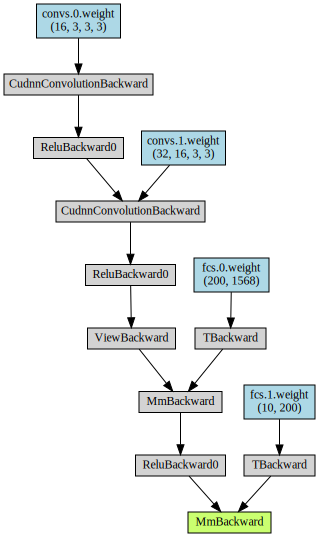

In [37]:
class ML(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs, self.fcs = nn.ModuleList(), nn.ModuleList()
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################     
        ## Bias set to false to match the structure that TA gave
        self.convs.append(nn.Conv2d(3, 16, 3, stride=2, bias=False)).cuda()# conv1.weight(16, 3, 3, 3)
        self.convs.append(nn.Conv2d(16, 32, 3, stride=2, bias=False)).cuda() # conv2.weight(32, 16, 3, 3)
        self.fcs.append(nn.Linear(1568, 200, bias=False)).cuda() # fc1.weight(200, 1568)
        self.fcs.append(nn.Linear(200, 10, bias=False)).cuda() # fc2.weight(10, 200)
        ###############################################################################
        #                            END TO DO                                        #
        ############################################################################### 
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################          
        ## For convolution list
        for i in range(0, len(self.convs)):
            x = F.relu(self.convs[i](x)).cuda()
        ## Flatten the matrix
        x = flatten(x).cuda()
        ## For fcs list
        for i in range(0, len(self.fcs)):
            x = self.fcs[i](x)
            if (i != len(self.fcs)-1):
                x = F.relu(x).cuda()
        out = x        
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################             
        return out
    
model = ML()
x = torch.zeros((BATCH_SIZE, 3, 32, 32)).cuda()
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 1.424 Acc 0.523
[  1/5] Training Step 100 Loss 1.477 Acc 0.508
[  1/5] Training Step 200 Loss 1.515 Acc 0.469
[  1/5] Training Step 300 Loss 1.593 Acc 0.438
[  1/5] Validate Step 007 Loss 1.547 Acc 0.460
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.499 Acc 0.508
[  2/5] Training Step 100 Loss 1.478 Acc 0.484
[  2/5] Training Step 200 Loss 1.524 Acc 0.469
[  2/5] Training Step 300 Loss 1.703 Acc 0.453
[  2/5] Validate Step 007 Loss 1.475 Acc 0.481
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Loss 1.507 Acc 0.438
[  3/5] Training Step 100 Loss 1.510 Acc 0.445
[  3/5] Training Step 200 Loss 1.514 Acc 0.461
[  3/5] Training Step 300 Loss 1.423 Acc 0.500
[  3/5] Validate Step 007 Loss 1.446 Acc 0.487
---------------- Epoch 3 ----------------
[  4/5] Training Step 000 Loss 1.481 Acc 0.484
[  4/5] Training Step 100 Loss 1.321 Acc 0.523
[  4/5] Training Step 200 Loss 1.

## Part4 Sequential
In this part, you have to complete the implentation of CNN with Sequential API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

In [45]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

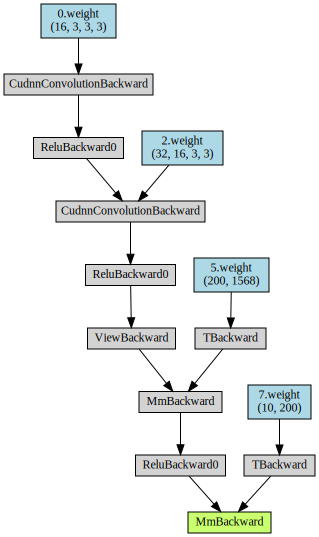

In [47]:
model = None
###############################################################################
#            TODO : Implement the Sequential API to complete the model        #
###############################################################################          
model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, bias=False).cuda(), 
                      nn.ReLU().cuda(),
                      nn.Conv2d(16, 32, 3, stride=2, bias=False).cuda(),
                      nn.ReLU().cuda(),
                      Flatten(),
                      nn.Linear(1568, 200, bias=False).cuda(),
                      nn.ReLU().cuda(),
                      nn.Linear(200, 10, bias=False).cuda())          
###############################################################################
#                            END TO DO                                        #
###############################################################################  


x = torch.zeros((BATCH_SIZE, 3, 32, 32)).cuda()
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.304 Acc 0.125
[  1/5] Training Step 100 Loss 2.280 Acc 0.234
[  1/5] Training Step 200 Loss 2.212 Acc 0.234
[  1/5] Training Step 300 Loss 2.098 Acc 0.250
[  1/5] Validate Step 007 Loss 2.038 Acc 0.288
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 2.101 Acc 0.297
[  2/5] Training Step 100 Loss 1.973 Acc 0.352
[  2/5] Training Step 200 Loss 1.937 Acc 0.312
[  2/5] Training Step 300 Loss 1.650 Acc 0.398
[  2/5] Validate Step 007 Loss 1.857 Acc 0.355
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Loss 1.859 Acc 0.375
[  3/5] Training Step 100 Loss 1.980 Acc 0.320
[  3/5] Training Step 200 Loss 1.639 Acc 0.391
[  3/5] Training Step 300 Loss 1.798 Acc 0.414
[  3/5] Validate Step 007 Loss 1.750 Acc 0.402
---------------- Epoch 3 ----------------
[  4/5] Training Step 000 Loss 1.769 Acc 0.414
[  4/5] Training Step 100 Loss 1.536 Acc 0.391
[  4/5] Training Step 200 Loss 1.

## Part 5 CIFAR-10 open-ended challenge
In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10
### Baseline : 65% on Testing data!!!

In [82]:
# model = None
optimizer = None
###############################################################################
#                               TODO                                          #
###############################################################################          
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

EPOCHS = 10
BATCH_SIZE = 128
PRINT_FREQ = 100
TRAIN_NUMS = 64000
###############################################################################
#                            END TO DO                                        #
###############################################################################  
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, stride=1).cuda()
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1, stride=1).cuda()
        self.pool1 = nn.MaxPool2d(2, 2).cuda()
        self.bn1 = nn.BatchNorm2d(64).cuda()
        self.relu1 = nn.ReLU().cuda()

        self.conv3 = nn.Conv2d(64, 256, 3, padding=1, stride=1).cuda()
        self.conv4 = nn.Conv2d(256, 1024, 3, padding=1, stride=1).cuda()
        self.pool2 = nn.MaxPool2d(2, 2).cuda()
        self.bn2 = nn.BatchNorm2d(1024).cuda()
        self.relu2 = nn.ReLU().cuda()

        self.fc14 = nn.Linear(65536,1024).cuda()
        self.drop1 = nn.Dropout2d().cuda()
        self.fc15 = nn.Linear(1024,128).cuda()
        self.drop2 = nn.Dropout2d().cuda()
        self.fc16 = nn.Linear(128,10).cuda()

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = flatten(x)
        
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)
        return x
    
model = MyCNN()
x = torch.zeros((BATCH_SIZE, 3, 32, 32)).cuda()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.005, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/10] Training Step 000 Loss 2.308 Acc 0.109
[  1/10] Training Step 100 Loss 1.588 Acc 0.430
[  1/10] Training Step 200 Loss 1.522 Acc 0.430
[  1/10] Training Step 300 Loss 1.193 Acc 0.562
[  1/10] Validate Step 007 Loss 1.079 Acc 0.617
---------------- Epoch 1 ----------------
[  2/10] Training Step 000 Loss 0.949 Acc 0.664
[  2/10] Training Step 100 Loss 1.028 Acc 0.680
[  2/10] Training Step 200 Loss 1.006 Acc 0.602
[  2/10] Training Step 300 Loss 0.920 Acc 0.648
[  2/10] Validate Step 007 Loss 0.872 Acc 0.706
---------------- Epoch 2 ----------------
[  3/10] Training Step 000 Loss 1.065 Acc 0.633
[  3/10] Training Step 100 Loss 0.858 Acc 0.719
[  3/10] Training Step 200 Loss 0.790 Acc 0.734
[  3/10] Training Step 300 Loss 0.853 Acc 0.711
[  3/10] Validate Step 007 Loss 0.784 Acc 0.724
---------------- Epoch 3 ----------------
[  4/10] Training Step 000 Loss 0.732 Acc 0.766
[  4/10] Training Step 100 Loss 0.673 Acc 0.773
[  4/10] Trainin

### 請解釋你如何建構的

<p>寫的時候參考這篇https://blog.csdn.net/briblue/article/details/84325722</p>
<p>主要參考的是API的用法，畢竟官方doc好多，想說參考先人知識會比較快上手</p>
<p>參考資料裡面大部分的東西看不懂，還在研究中</p>
<p>首先optimizer 一樣使用SGD，有聽其他人用ADAM效果比較好，單純覺得無聊就堅持用SGD(另外因為有cuda跑比較快所以想說沒差)</p>
<p>lr調整至0.005,測試幾次發現效果比較好的</p>
<p>太高會變差，太低也會變差</p>
<p>其他如criterion等照舊(我也還看不懂)</p>
<p>基本上就是做兩次conv後，一次maxpool，一次batch normalization，一次ReLU，重複兩次後得到的結果</p>
<br/>
<p>原本是想說疊加幾層conv應該就能夠得到比較好的結果</p>
<p>發現沒效，就想說增加epoch跟batch size</p>
<p>training的過程中，Acc有增加，但是test的時候還是不太好</p>
<p>甚至有training set Acc = 1, test set Acc = 0.6的悲劇情況</p>
<p>想到有可能是overfitting的關係</p>
<p>利用一些處理overfitting的方式</p>
<p>於是參考上面那篇，將batch normalization, maxpooling, dropout等減少overfitting的API放進去</p>
<p>就發現跑出來>0.65了(灑花)</p>
<br/>
<p>目前還是覺得這東西好黑盒子</p>
<p>之後開始做project的時候，需要好好探討減少overfitting的同時也要改進速度，不然目前還是偏慢</p>